# Race Studio 3 Data Processing

<div class="alert alert-block alert-success">
<b>TLDR:</b> Scroll to the <a href="#work-with-data" title="Work With Data">Work With Data</a> section at the bottom of this notebook to begin working with the RaceStudio3 data.  Everything above is related to configuration and data processing.
</div>

# Initial Configuration

Run this module before running anything else.

## Install Necessary Python Packages

In [23]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Initialize Python Packages

In [24]:
import pint
import pandas as pd
import pint_pandas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from typing import Iterable, Optional

u = pint.UnitRegistry()
Q_ = u.Quantity
u.define('percent = pct = dimensionless / 100')
u.define('gear = dimensionless')

pint_pandas.PintType.ureg = u
pint_pandas.PintType.ureg.setup_matplotlib()

# Utility Functions

## Data Manipulation and Exporting Functions

Useful functions that handle exporting data to `.csv` files, converting series to their base-unit values, and more.

In [25]:
def convert_to_magnitude(data: pd.DataFrame | pd.Series, units: str) -> pd.DataFrame | pd.Series:
    return data.apply(lambda val: val.to(units).value)


def magnitude_of_df_col(column_name: str, df: pd.DataFrame, units: dict[str, str]) -> pd.DataFrame | pd.Series:
    return convert_to_magnitude(df[column_name], units[column_name])


def strip_df_of_units(
        data_df: pd.DataFrame | pd.Series,
        rename_cols_with_units: bool = True
    ) -> pd.DataFrame | pd.Series:
    """
    Strip units from a pandas DataFrame or Series object, with an
    option to rename columns/series to include original unit
    information.

    This function processes pandas objects that have Pint quantities
    (data associated with units), converting all quantities to their
    base units.  Optionally, it appends the original unit information
    to the names of each column in a DataFrame or the name of a
    Series. The renaming can be controlled by the
    `rename_cols_with_units` parameter.

    Parameters
    ----------
    data_df : pd.DataFrame | pd.Series
        The pandas DataFrame or Series to be stripped of units.  Must
        contain Pint quantities.
    rename_cols_with_units : bool, optional
        If True (default), the column or series names will be updated
        to include the original unit information.  If False, names
        will remain unchanged.

    Returns
    -------
    pd.DataFrame | pd.Series
        A new DataFrame or Series with all quantities converted to
        base units.  If `rename_cols_with_units` is True, the original
        units are appended to the column/series names; otherwise, the
        names are unchanged.

    Raises
    ------
    TypeError
        If `data_df` is neither a pandas DataFrame nor a Series.

    Examples
    --------
    >>> import pandas as pd
    >>> import pint_pandas
    >>> ureg = pint_pandas.PintTypeRegistry()
    >>> data = {'length': [1, 2, 3] * ureg.meter, 'time': [10, 20, 30] * ureg.second}
    >>> df = pd.DataFrame(data)
    >>> strip_df_of_units(df)
    >>> strip_df_of_units(df, rename_cols_with_units=False)
    """
    incorrect_type_error = TypeError(f'data_df must be a pd.Dataframe or a pd.Series, but instead it is of type "{type(data_df)}"')

    if isinstance(data_df, pd.DataFrame):
        if rename_cols_with_units is True:
            column_names = {original_name: f'{original_name} ({series.pint.to_base_units().units})' for original_name, series in data_df.items()}
            return data_df.copy().rename(columns=column_names).pint.to_base_units().pint.magnitude
        else:
            new_df: pd.DataFrame = data_df.copy().pint.dequantify()
            new_df.columns = [col[0] for col in new_df.columns.values]
            return new_df

    elif isinstance(data_df, pd.Series):
        if rename_cols_with_units is True:
            name = f'{data_df.name} ({data_df.pint.to_base_units().pint.units})'
        else:
            name = data_df.name

        return pd.Series(name=name, data=data_df.copy().pint.to_base_units().pint.magnitude)

    raise incorrect_type_error


def export_data_to_csv(
        time_df: pd.DataFrame | pd.Series,
        data_dfs: pd.DataFrame | Iterable[pd.Series],
        filename: str
    ) -> None:
    """
    Export time series data and associated data series to a CSV file.

    This function combines a time series (either a DataFrame or
    Series) with multiple data series, strips them of units using
    `strip_df_of_units`, and exports the resulting DataFrame to a CSV
    file.  The names of time and data series are updated to include
    original unit information.

    Parameters
    ----------
    time_df : pd.DataFrame | pd.Series
        The time series DataFrame or Series, which should include Pint
        quantities.  The time series data is used as the index in the
        exported CSV.
    data_dfs : pd.DataFrame | Iterable[pd.Series]
        An iterable of pandas Series objects representing the data to
        be exported alongside the time series. Each series must have
        Pint quantities.
    filename : str
        The name of the file to which the combined data will be
        exported.

    Raises
    ------
    TypeError
        If `data_dfs` is not an Iterable of pd.Series or a pd.Series.

    Examples
    --------
    >>> import pandas as pd
    >>> import pint_pandas
    >>> ureg = pint_pandas.PintTypeRegistry()
    >>> time_data = pd.Series([1, 2, 3], name='time') * ureg.hour
    >>> data_series = pd.Series([4, 5, 6], name='speed') * ureg.meter / ureg.second
    >>> export_data_to_csv(time_data, data_series, 'output.csv')

    >>> export_data_to_csv(RACE_DATA_DF['Time'], [speed_during_coast, acceleration_during_coast, RACE_DATA_DF['GPS G Sum'], RACE_DATA_DF['GPS Latitude']], "some_data.csv")
    """
    incorrect_type_error = TypeError(f'data_dfs must be an Iterable of pd.Series or a pd.Series, but instead it is of type "{type(data_dfs)}"')
    export_df = pd.DataFrame()
    unitless_time_series = strip_df_of_units(time_df)
    export_df[unitless_time_series.name] = unitless_time_series

    if isinstance(data_dfs, pd.Series):
        data_dfs = [data_dfs]

    elif isinstance(data_dfs, pd.DataFrame):
        data_dfs = [series for _, series in data_dfs.copy().items()]

    if isinstance(data_dfs, Iterable):
        for column_data in data_dfs:
            assert isinstance(column_data, pd.Series), incorrect_type_error
            unitless_column = strip_df_of_units(column_data)
            export_df[unitless_column.name] = unitless_column
    else:
        raise incorrect_type_error

    export_df.to_csv(filename)

## Plotting Functions

Helper functions to simplify the data-plotting process.

In [26]:
def plot_race_data(
        race_data: pd.DataFrame,
        units: dict[str, str],
        x_series: str,
        y_series: str,
    ) -> None:
    """Given the master RACE_DATA dataframe, this function plots the
    data given an x_column name of the dataframe and a y_column name
    of the dataframe.

    Parameters
    ----------
    race_data : pd.DataFrame
        Master dataframe to get x- and y-values from, where `x_series`
        and `y_series` are column keys of the dataframe
    units : dict[str, str]
        Units dictionary for a race data dataframe
    x_series : str
        Name of the column/key to use for the x-values of the plot
    y_series : str
        Name of the column/key to use for the y-values of the plot
    """
    x_data = convert_to_magnitude(race_data[x_series], units[x_series])
    y_data = convert_to_magnitude(race_data[y_series], units[y_series])
    plot_data(x_data, f'{x_series} ({units[x_series]})', y_data, f'{y_series} ({units[y_series]})')


def plot_data(
        x_data: pd.DataFrame | pd.Series,
        x_label: str,
        y_data: pd.DataFrame | pd.Series,
        y_label: str
    ) -> None:
    """
    Plot data from pandas DataFrame or Series.

    This function takes x and y data in the form of pandas DataFrame
    or Series, and labels for the x and y axes. It then plots the data
    using matplotlib's plt.plot function and labels the axes
    accordingly.

    Parameters
    ----------
    x_data : pd.DataFrame | pd.Series
        Data for the x-axis. Must be a pandas DataFrame or Series.
    x_label : str
        Label for the x-axis.
    y_data : pd.DataFrame | pd.Series
        Data for the y-axis. Must be a pandas DataFrame or Series.
    y_label : str
        Label for the y-axis.

    Examples
    --------
    >>> import pandas as pd
    >>> x = pd.Series([1, 2, 3, 4])
    >>> y = pd.Series([1, 4, 9, 16])
    >>> plot_data(x, 'Time', y, 'Distance')
    """
    plt.plot(x_data, y_data)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

# Initialize Race Data from Spreadsheet

This code takes formatted race data from a `.csv` file and parses it into [`Pandas Dataframes`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), [`Pint`](https://pint.readthedocs.io/en/stable/) Unit objects, and [`Pint Pandas`](https://pint.readthedocs.io/en/0.18/pint-pandas.html) dataframe extension so that computations can be easily performed on the data.

## Compute Laps

Since the data exported from RaceStudio3 does not include the lap number or lap-related parameters, the below codeblock uses ML to determine the probable location of the start of the lap (based on the `GPS Latitude` and `GPS Longitude` values and their repetitiveness).  It then initializes a bunch of Lap-specific parameters that would be useful for the analysis.

In [27]:
def identify_starting_point(df: pd.DataFrame):
    # Use DBSCAN to cluster points based on geographical location
    # eps is the maximal distance between two samples for one to be considered as in the neighborhood of the other, 
    # in this case, it's set to roughly 50 meters (adjust based on your specific dataset)
    kms_per_radian = 6371.0088
    epsilon = 0.05 / kms_per_radian  # convert to radians for the haversine formula
    db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(
        np.radians(strip_df_of_units(df[['GPS Latitude', 'GPS Longitude']], rename_cols_with_units=False)))
    cluster_labels = db.labels_
    # Find the cluster that has the most points (most likely to be the start/finish line)
    largest_cluster = np.argmax(np.bincount(cluster_labels[cluster_labels >= 0]))
    
    # Compute the centroid of the largest cluster
    largest_cluster_indices = np.where(cluster_labels == largest_cluster)
    largest_cluster_points = df.iloc[largest_cluster_indices]
    centroid = (largest_cluster_points['GPS Latitude'].mean(), largest_cluster_points['GPS Longitude'].mean())
    return centroid


def find_laps(df: pd.DataFrame):
    minimal_df = strip_df_of_units(df[['dT', 'GPS Latitude', 'GPS Longitude']], rename_cols_with_units=False)
    # Identify the starting point (most visited point, likely to be the start/finish line)
    start_lat, start_lon = identify_starting_point(minimal_df)
    
    # Threshold for considering the car has passed the start/finish line (in kilometers)
    threshold = 0.05
    
    # Initialize lap counter and list to store the lap number for each point
    current_lap = 1
    current_lap_time = 0
    lap_numbers = []
    lap_times = []

    for index, row in minimal_df.iterrows():
        distance_from_start = great_circle((start_lat, start_lon), (row['GPS Latitude'], row['GPS Longitude'])).kilometers
        
        is_new_lap = (
            distance_from_start <= threshold and    # Ensure distance from starting point is reasonable
            index > 0 and                           # Avoid counting the first point if it's close to the start
            (
                current_lap_time >= 10 or           # Ensure the current lap is at least 10 seconds long
                current_lap == 1                    # Or skip this check if this is the first lap
            )
        )
        current_lap_time += row['dT']

        if is_new_lap:  # Avoid counting the first point if it's close to the start
            current_lap += 1
            current_lap_time = 0

        lap_numbers.append(current_lap)
        lap_times.append(current_lap_time)

    df['Lap Number'] = pd.Series(data=lap_numbers, name='Lap Number', dtype='pint[dimensionless]')
    df['Current Lap Time'] = pd.Series(data=lap_times, name='Lap Time', dtype='pint[second]')

    return df

## Set Custom Columns

This is where custom columns and math channels are defined.  The master `RACE_DATA_DF` dataframe includes all race data, including columns for these newly defined channels.

In [28]:
def set_dt(df: pd.DataFrame, units: dict[str, str]) -> None:
    label = 'dT'
    units[label] = 'sec'
    df[label] = df['Time'].diff().fillna(0)  # Calculate time difference between measurements


def set_acceleration(df: pd.DataFrame, units: dict[str, str]) -> None:
    label = 'Acceleration'
    units[label] = 'm/(s^2)'
    df[label] = (df['GPS Speed'].diff().fillna(0) / df['dT'].replace(0, np.nan))  # Avoid division by zero


def set_Distance_on_GPS_Speed(df: pd.DataFrame, units: dict[str, str]) -> None:
    """Set "Distance on GPS Speed" Math Channel

    Distance on GPS Speed.

    Parameters
    ----------
    df : pd.DataFrame
        Race Data Dataframe
    units : dict[str, str]
        Units dictionary for a race data dataframe
    """
    label = 'Distance on GPS Speed'
    units[label] = 'm'
    df[label] = (df['GPS Speed'].shift().fillna(0) * df['dT'].shift().fillna(0)).cumsum()


def set_GPS_G_Sum(df: pd.DataFrame, units: dict[str, str]) -> None:
    """Set "GPS G Sum" Math Channel

    Outputs the abs value of the sum of the inline and lateral
    acceleration channels values.

    Parameters
    ----------
    df : pd.DataFrame
        Race Data Dataframe
    units : dict[str, str]
        Units dictionary for a race data dataframe
    """
    label = 'GPS G Sum'
    units[label] = 'gravity'
    df[label] = (df['GPS LonAcc']**2 + df['GPS LatAcc']**2)**(1/2)


def set_GPS_BRK_On(df: pd.DataFrame, units: dict[str, str]) -> None:
    """Set "GPS BRK On" Math Channel

    Computes when the inline acceleration g's are less than -0.15g.
    The outputs are : 0 = Brakes are off, 1 = Brakes are on.

    Parameters
    ----------
    df : pd.DataFrame
        Race Data Dataframe
    units : dict[str, str]
        Units dictionary for a race data dataframe
    """
    label = 'GPS BRK On'
    units[label] = 'dimensionless'
    df[label] = pd.Series(np.where(df['GPS LonAcc'] < Q_(-0.15, 'gravity'), Q_(1, units[label]), Q_(0, units[label])), dtype=f'pint[{units[label]}]')


def set_GPS_TPS_On(df: pd.DataFrame, units: dict[str, str]) -> None:
    """Set "GPS TPS On" Math Channel

    Computes when the inline acceleration g's are greater than 0.05g.
    The outputs are: 0 = Throttle is off, 1 = Throttle is on.

    Parameters
    ----------
    df : pd.DataFrame
        Race Data Dataframe
    units : dict[str, str]
        Units dictionary for a race data dataframe
    """
    label = 'GPS TPS On'
    units[label] = 'dimensionless'
    df[label] = pd.Series(np.where(df['GPS LonAcc'] > Q_(0.05, 'gravity'), Q_(1, units[label]), Q_(0, units[label])), dtype=f'pint[{units[label]}]')


def set_GPS_CRN_On(df: pd.DataFrame, units: dict[str, str]) -> None:
    """Set "GPS CRN On" Math Channel

    Computes when the lateral acceleration is greater than 0.2g. The
    outputs are: 0 = On a straight, 1 = In a corner.

    Parameters
    ----------
    df : pd.DataFrame
        Race Data Dataframe
    units : dict[str, str]
        Units dictionary for a race data dataframe
    """
    label = 'GPS CRN On'
    units[label] = 'dimensionless'
    df[label] = pd.Series(np.where(abs(df['GPS LatAcc']) > Q_(0.2, 'gravity'), Q_(1, units[label]), Q_(0, units[label])), dtype=f'pint[{units[label]}]')


def set_GPS_CST_On(df: pd.DataFrame, units: dict[str, str]) -> None:
    """Set "GPS CST On" Math Channel

    Computes when the driver is not on the brakes, and not on the
    throttle, and not in a corner. The outputs are: 0 = Not coasting,
    1 = Coasting.

    Parameters
    ----------
    df : pd.DataFrame
        Race Data Dataframe
    units : dict[str, str]
        Units dictionary for a race data dataframe
    """
    label = 'GPS CST On'
    units[label] = 'dimensionless'
    zero = Q_(0, units[label])
    df[label] = pd.Series(np.where((df['GPS BRK On'] == zero) & (df['GPS TPS On'] == zero) & (df['GPS CRN On'] == zero), Q_(1, units[label]), Q_(0, units[label])), dtype=f'pint[{units[label]}]')


def initialize_channels(race_data: pd.DataFrame, units: dict[str, str]) -> None:
    ## SET NEW COLUMNS
    set_dt(df=race_data, units=units)
    set_Distance_on_GPS_Speed(df=race_data, units=units)
    set_GPS_G_Sum(df=race_data, units=units)
    set_GPS_BRK_On(df=race_data, units=units)
    set_GPS_TPS_On(df=race_data, units=units)
    set_GPS_CRN_On(df=race_data, units=units)
    set_GPS_CST_On(df=race_data, units=units)

    # set_acceleration(race_data)

## Build RaceStudio3 Dataframe

This is the code that initializes the data structure to be used throughout this Jupyter Notebook.

In [29]:
def generate_units_dict(csv_filepath: str, units: dict[str, str]) -> dict[str, str]:
    """
    Generate a dictionary of units from a CSV file.

    This function reads the first row of a CSV file specified by the
    file path.  It then generates and returns a dictionary where each
    key-value pair corresponds to a column label and its associated
    unit. If a unit is not specified (empty or consisting only of
    spaces) for a label, it is replaced with 'dimensionless'.
    Additionally, any spaces are removed from the units, and
    percentage symbols are replaced with the word 'percent'.

    Parameters
    ----------
    csv_filepath : str
        The file path to the CSV file from which units are to be
        extracted.
    units : dict[str, str]
        Units dictionary for a race data dataframe

    Returns
    -------
    dict[str, str]
        A dictionary where each key is a column label from the CSV and
        each value is the cleaned unit associated with that label.
        'Dimensionless' is used for labels without specified units.

    Examples
    --------
    >>> generate_units_dict('data.csv')
    {'Temperature': 'Celsius', 'Humidity': 'percent', 'Pressure': 'dimensionless'}
    """
    units_data = pd.read_csv(
        filepath_or_buffer=csv_filepath,
        nrows=1,
    ).to_dict(orient='list')

    for label, unit in units_data.items():
        if unit[0].replace(' ', '') == '':
            unit[0] = 'dimensionless'
        units[label] = unit[0].replace(' ', '').replace('%', 'percent')

    return units


def load_race(race_data_filepath: str, units: dict[str, str]) -> pd.DataFrame:
    """
    Load race data from a CSV file and quantify the units using Pint.

    This function reads race data from a specified CSV file.  The CSV
    file is expected to have a multi-level header, with the first
    level being the data labels and the second level being the units.
    After loading the data, it uses the `generate_units_dict` function
    to process and clean the units from the same CSV file.  Finally,
    the function applies Pint's quantify method to the data frame,
    which assigns the units to the data based on the second level of
    the header, allowing for unit-aware calculations.

    Parameters
    ----------
    race_data_filepath : str
        The file path to the CSV file containing the race data.
    units : dict[str, str]
        Dictionary mapping column name keys to the units the column's
        data is stored in.

    Returns
    -------
    pandas.DataFrame
        A pandas DataFrame containing the race data, with units
        applied to the data according to the second header row of the
        CSV file.  This DataFrame is compatible with Pint for
        unit-aware calculations.

    Examples
    --------
    >>> RACE_DATA_DF = load_race('race_data.csv')
    >>> RACE_DATA_DF.dtypes
    <output showing data types and units>
    """
    race_data = pd.read_csv(
        filepath_or_buffer=race_data_filepath,
        header=[0,1],
    )

    generate_units_dict(csv_filepath=race_data_filepath, units=units)

    race_data_df = race_data.pint.quantify(level=-1)

    initialize_channels(race_data=race_data_df, units=units)
    find_laps(race_data_df)

    return race_data_df

# Work with Data

## Load in Data

Define the filepath of the data file you are trying to load in, as well as the corresponding `units` dictionary containing that dataset's units values.

> The `units` dictionary is helpful, but not critical due to Pint's builtin unit-handling capabilities.  This is a remnant of an older implementation of some functionality that @HenryAsa hasn't yet removed.

In [30]:
RACE_DATA_FILEPATH = "data/formatted/BETTER_20230831_143833_Blair Hosie_Rush SR 150_Palmer ACW_a_0045.csv"
UNITS: dict[str, str] = {}

RACE_DATA_DF = load_race(race_data_filepath=RACE_DATA_FILEPATH, units=UNITS)
"""All Race Data stored in a Pandas Dataframe with Pint Units built-in to handle unit conversions and unit operations"""

'All Race Data stored in a Pandas Dataframe with Pint Units built-in to handle unit conversions and unit operations'

## Generate Plots for Data

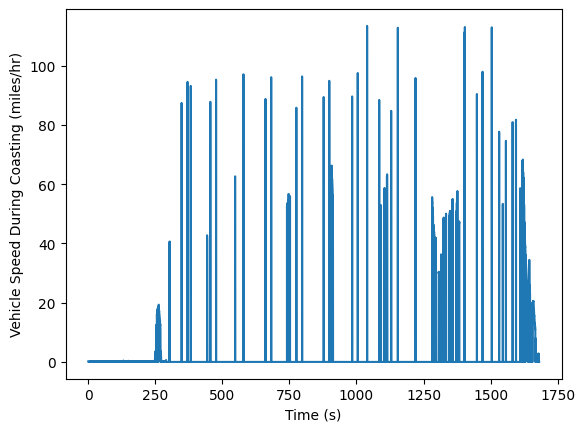

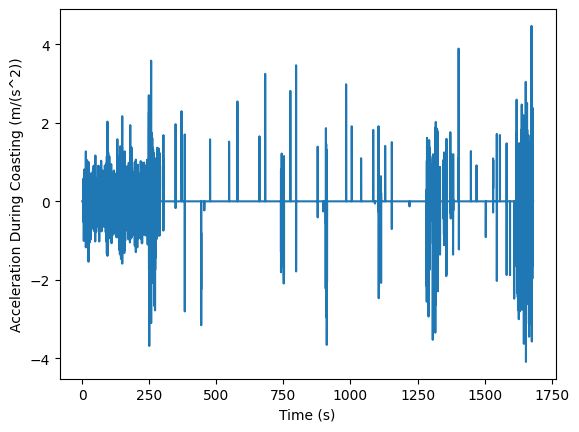

In [31]:
speed_during_coast = pd.Series(RACE_DATA_DF['GPS Speed'] * RACE_DATA_DF['GPS CST On'], name='Speed During Coasting')
plot_data(RACE_DATA_DF['Time'], f'Time ({UNITS["Time"]})', speed_during_coast.pint.to('miles/hr'), 'Vehicle Speed During Coasting (miles/hr)')

acceleration_during_coast = pd.Series(RACE_DATA_DF['GPS Speed'].diff().fillna(0) * RACE_DATA_DF['GPS CST On'] / RACE_DATA_DF['dT'].replace(0, np.nan), name='Acceleration During Coasting')
plot_data(RACE_DATA_DF['Time'], f'Time ({UNITS["Time"]})', acceleration_during_coast.pint.to('m/(s^2)'), 'Acceleration During Coasting (m/(s^2))')

## Determine Drag Coefficient of the Vehicle

$$F_D = \frac{1}{2}\rho v^2 C_D A$$
where $F_D$ is the drag force, $\rho$ is the density of the fluid (air), $v$ is the speed of the vehicle relative to the fluid, $C_D$ is the drag coefficient, and $A$ is the cross-sectional area of the vehicle.

Rearranged, the coefficient of drag can be determined by:

$$C_D = \frac{2 F_D}{\rho v^2 A}$$

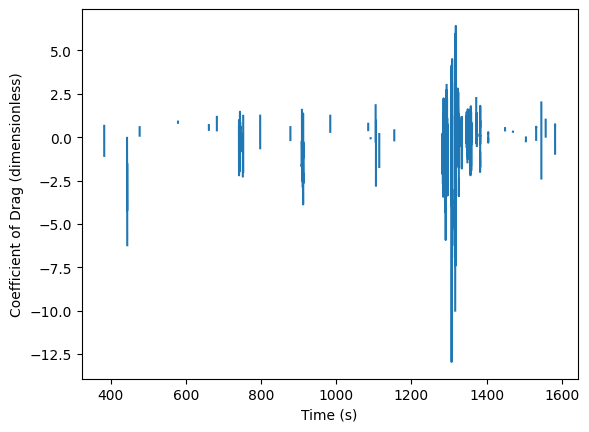

In [38]:
### DEFINE CONSTANTS FOR CALCS ####
mass_driver = 175 * u.lbs
"""Assumed mass of the driver"""
mass_car = 513 * u.kg       # https://rushautoworks.com/car_post/rush-sr/#:~:text=Weight%3A%20513kg%20/%201130lbs
"""Mass of just the vehicle"""

vehicle_width = 1500 * u.mm # https://rushautoworks.com/car_post/rush-sr/#:~:text=Wheelbase%3A%201900mm%20/%2075%E2%80%B3-,Width%3A%201500mm%20/%2059%E2%80%B3,-Height%3A%20990mm%20/%2038.9
"""Width of the vehicle"""
vehicle_height = 990 * u.mm # https://rushautoworks.com/car_post/rush-sr/#:~:text=Height%3A%20990mm%20/%2038.9%E2%80%B3
"""Height of the vehicle"""

rho_air = 1.2041 * (u.kg / (u.m**3))    # Air density at 20 degrees C
"""Density of air at 20 degrees C"""
####################################


def slice_into_df(
        df: pd.DataFrame,
        start_index: Optional[int] = None,
        end_index: Optional[int] = None,
    ) -> pd.DataFrame:
    if start_index is None: start_index = 0
    if end_index is None or end_index > len(df) - 2:   end_index = len(df) - 2
    return df.iloc[start_index:end_index + 1] #.copy()


def get_lap_indices(
        df: pd.DataFrame,
        start_lap: int,
        end_lap: int,
    ) -> dict[int: list[int, int]]:
    lap_indices: dict[int, list[int, int]] = {}
    for lap_number in (start_lap, end_lap):
        lap_start_index = df.loc[RACE_DATA_DF['Lap Number'] == lap_number].index[0]
        lap_end_index = df.loc[RACE_DATA_DF['Lap Number'] == lap_number].index[-1]
        lap_indices[lap_number] = [lap_start_index, lap_end_index]
    
    return lap_indices

#### Drag Calculations ####
vehicle_cross_sectional_area = vehicle_height * vehicle_width
"""Frontal cross sectional area of the vehicle"""
mass_vehicle = mass_driver + mass_car
"""Mass of the vehicle including the driver"""

speed_during_coast = pd.Series(RACE_DATA_DF['GPS Speed'] * RACE_DATA_DF['GPS CST On'], name='Speed During Coasting')
acceleration_during_coast = pd.Series(RACE_DATA_DF['GPS Speed'].diff().fillna(0) * RACE_DATA_DF['GPS CST On'] / RACE_DATA_DF['dT'].replace(0, np.nan), name='Acceleration During Coasting')

drag_force = pd.Series(data=acceleration_during_coast * mass_vehicle, name='Drag Force')
drag_coefficient = pd.Series(data=((2*drag_force) / (rho_air * (speed_during_coast**2) * vehicle_cross_sectional_area)), name='Coefficient of Drag')
###########################

# first_lap_start_index = RACE_DATA_DF.loc[RACE_DATA_DF['Lap Number'] == 2].index[0]
# last_lap_end_index = RACE_DATA_DF.loc[RACE_DATA_DF['Lap Number'] == RACE_DATA_DF['Lap Number'].iloc[-1] - 1].index[-1]

start_lap_num = 2
end_lap_num = (RACE_DATA_DF['Lap Number'].iloc[-1] - 1).magnitude

lap_indices = get_lap_indices(RACE_DATA_DF, start_lap_num, end_lap_num)
start_lap_indices = lap_indices[start_lap_num]
end_lap_indices = lap_indices[end_lap_num]

valid_lap_times = slice_into_df(RACE_DATA_DF['Time'], start_lap_indices[0], end_lap_indices[-1])
valid_drag_coefficients = slice_into_df(drag_coefficient, start_lap_indices[0], end_lap_indices[-1])

plot_data(valid_lap_times, f'Time ({UNITS["Time"]})', valid_drag_coefficients.pint.to_base_units(), f'Coefficient of Drag ({valid_drag_coefficients.pint.to_base_units().pint.units})')

range(2, 13)


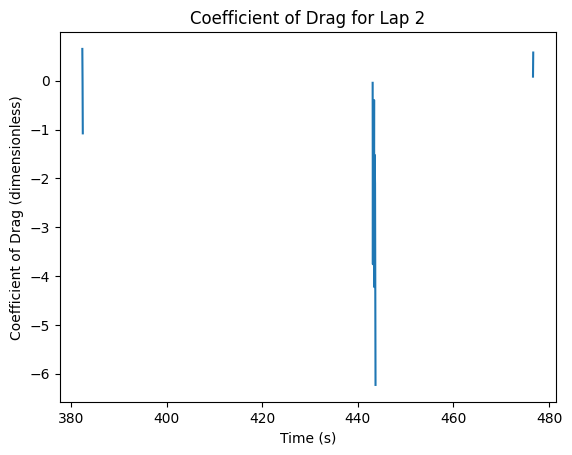

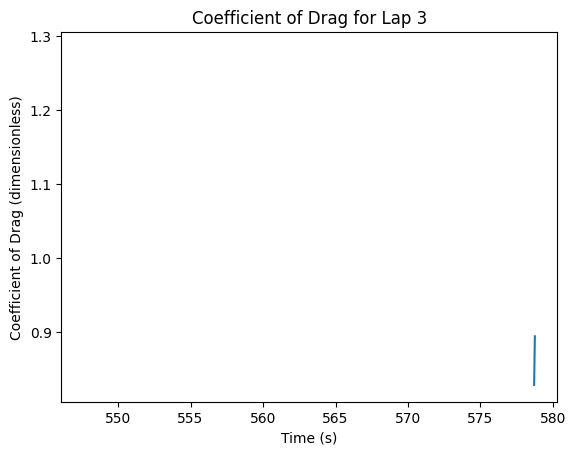

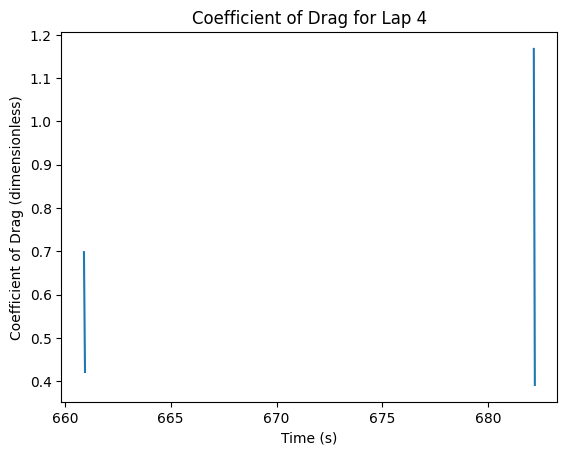

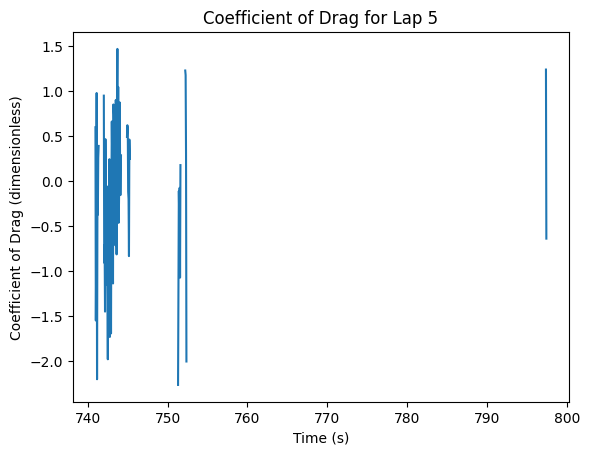

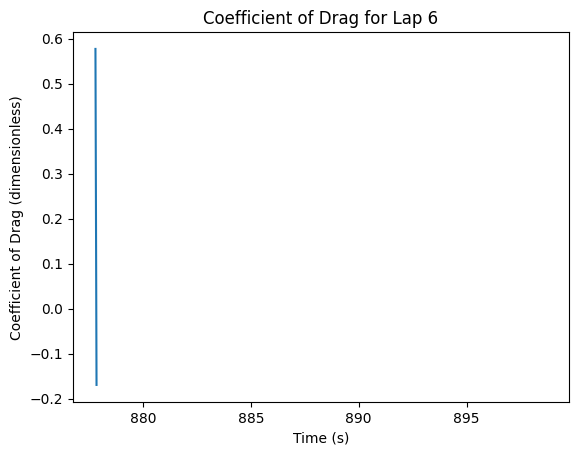

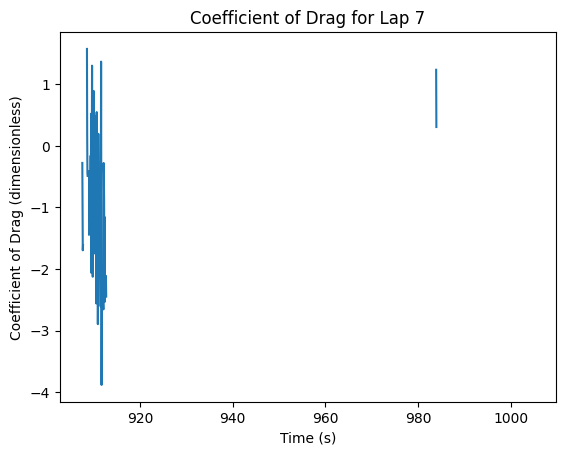

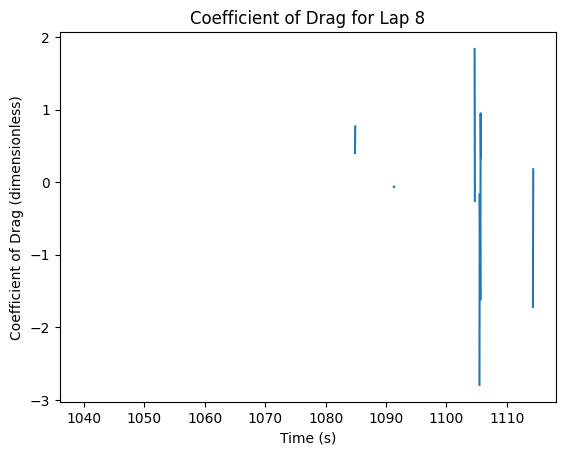

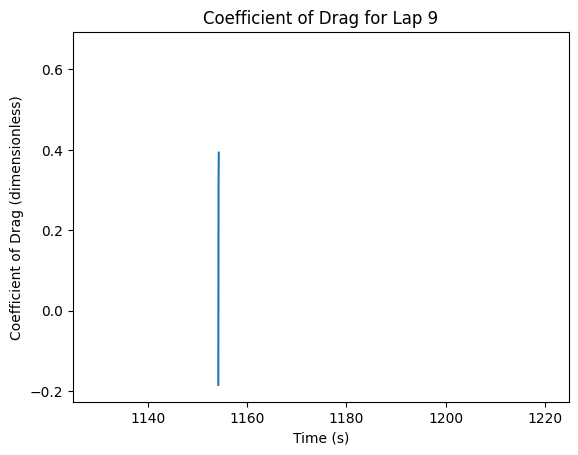

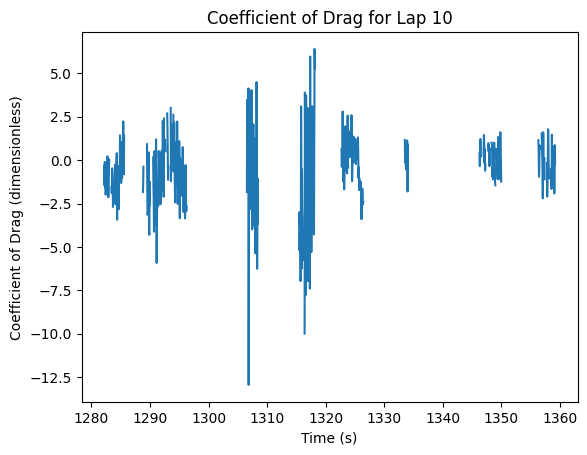

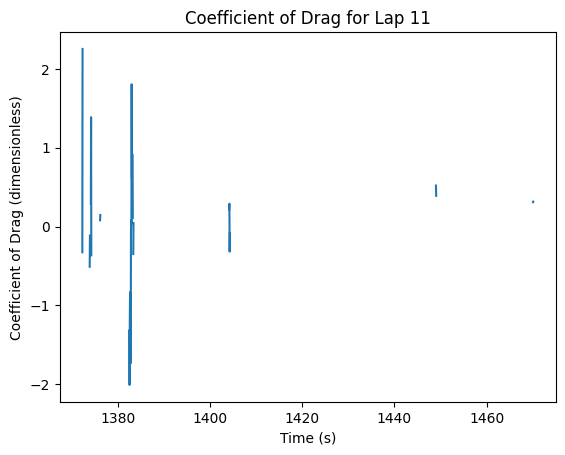

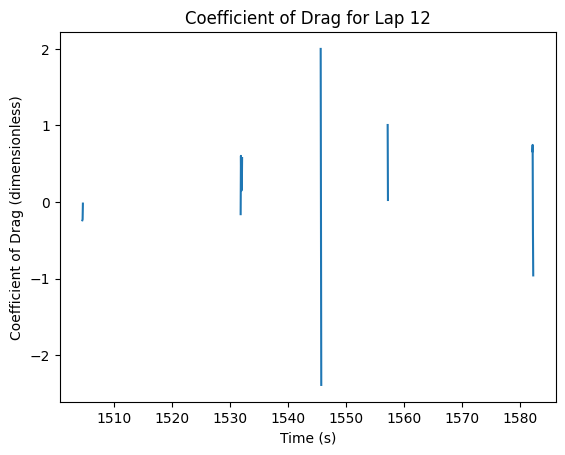

In [44]:
start_lap_num = 2
end_lap_num = (RACE_DATA_DF['Lap Number'].iloc[-1] - 1).magnitude

for lap_num in range(start_lap_num, end_lap_num+1):
    lap_indices = get_lap_indices(RACE_DATA_DF, lap_num, lap_num)
    start_lap_indices = lap_indices[lap_num]
    end_lap_indices = lap_indices[lap_num]

    valid_lap_times = slice_into_df(RACE_DATA_DF['Time'], start_lap_indices[0], end_lap_indices[-1])
    valid_drag_coefficients = slice_into_df(drag_coefficient, start_lap_indices[0], end_lap_indices[-1])

    plt.title(f'Coefficient of Drag for Lap {lap_num}')
    plot_data(valid_lap_times, f'Time ({UNITS["Time"]})', valid_drag_coefficients.pint.to_base_units(), f'Coefficient of Drag ({valid_drag_coefficients.pint.to_base_units().pint.units})')